In [7]:
import numpy as np
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import ot
import idx2numpy

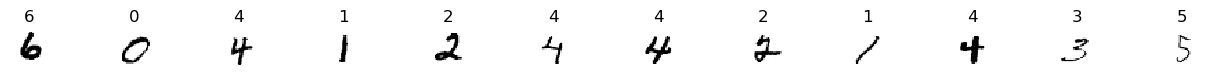

In [80]:
file = 'train-images.idx3-ubyte'
mnist_train_images = idx2numpy.convert_from_file(file)

file = 'train-labels.idx1-ubyte'
mnist_train_labels = idx2numpy.convert_from_file(file)


# visualize some digits
plt.figure(figsize=(16,0.5))
for i in range(12):
    plt.subplot(1, 12, i+1)
    idx = np.random.randint(mnist_train_images.shape[0])
    plt.imshow(mnist_train_images[idx], cmap='Greys')
    plt.title(mnist_train_labels[idx])
    plt.axis('off')

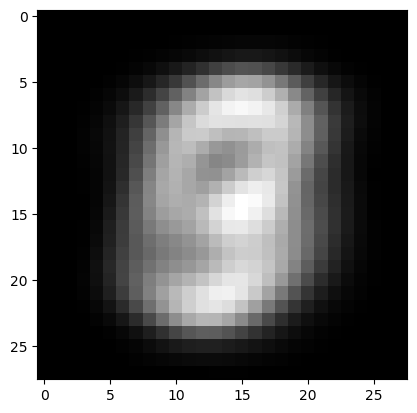

In [81]:
average_image = np.mean(mnist_train_images, axis=0)
ref = average_image/average_image.sum()
# Visualize the average image
plt.imshow(ref, cmap='gray')

In [82]:
# image size
N = 28

# create point clouds and associated masses
point_clouds, masses = {}, {}
for i in range(len(mnist_train_images)):
    # extract support of point cloud
    idxes = np.where(mnist_train_images[i]>0)
    cloud = np.zeros((len(idxes[0]), 2))
    cloud[:, 0] = idxes[1]/N
    cloud[:, 1] = 1 - idxes[0]/N
    point_clouds[i] = cloud
    # extract masses of point cloud
    nu = mnist_train_images[i][np.where(mnist_train_images[i]>0)] + 1
    masses[i] = np.zeros_like(ref)
    masses[i][np.where(mnist_train_images[i]>0)] = nu / np.sum(nu)

C:\Users\俩鱼儿\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  


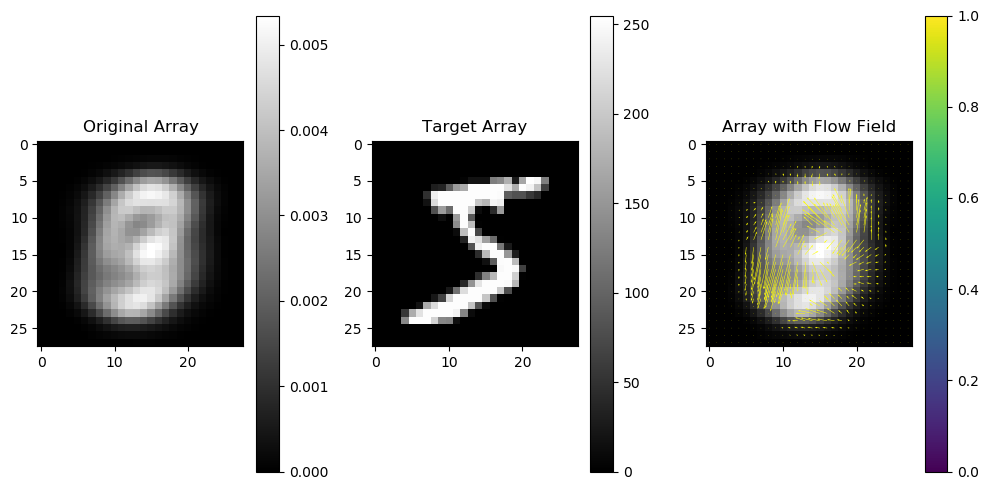

In [84]:
import ot
import numpy as np

# Example 28x28 arrays (replace these with your actual arrays)
array1 = ref
array2 = masses[0]

# Normalize the arrays
array1 /= array1.sum()
array2 /= array2.sum()

# Create a 4D cost matrix
xx1, yy1 = np.meshgrid(range(28), range(28))
xx2, yy2 = np.meshgrid(range(28), range(28))
X1 = np.stack([xx1.ravel(), yy1.ravel()], axis=-1)
X2 = np.stack([xx2.ravel(), yy2.ravel()], axis=-1)
M = ot.dist(X1, X2, metric='euclidean')
M = M.reshape(28, 28, 28, 28)

# Compute optimal transport plan
transport_plan = ot.emd(array1.ravel(), array2.ravel(), M.reshape(28*28, 28*28))

# transport_plan now contains the 2D optimal transport plan
transport_plan_reshaped = transport_plan.reshape(28, 28, 28, 28)

# Initialize a flow field
flow_field = np.zeros((28, 28, 2))

# Calculate the flow field
for i in range(28):
    for j in range(28):
        flow = np.zeros(2)
        for k in range(28):
            for l in range(28):
                flow += transport_plan_reshaped[i, j, k, l] * np.array([k-i, l-j])
        flow_field[i, j, :] = flow

# Visualizing the flow field
plt.figure(figsize=(10, 5))

# Original array
plt.subplot(1, 3, 1)
plt.title("Original Array")
plt.imshow(array1, cmap='gray')
plt.colorbar()
#taget arrau
plt.subplot(1, 3, 2)
plt.title("Target Array")
plt.imshow(mnist_train_images[0], cmap='gray')
plt.colorbar()

# Array with flow field
plt.subplot(1, 3, 3)
plt.title("Array with Flow Field")
plt.imshow(array1, cmap='gray')
plt.quiver(np.arange(28), np.arange(28), flow_field[:, :, 1], -flow_field[:, :, 0], color='yellow')
plt.colorbar()

plt.tight_layout()
plt.savefig("flow_field")
plt.show()

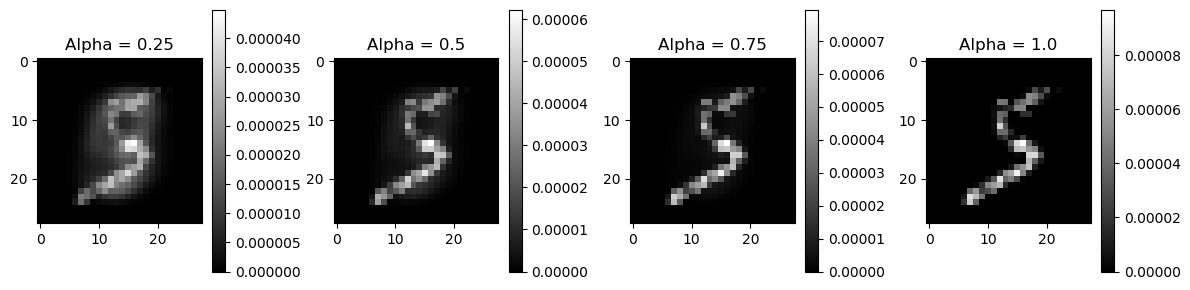

<Figure size 640x480 with 0 Axes>

In [74]:
def interpolate_distributions(array1, array2, alpha, transport_plan):
    interpolated_array = np.zeros_like(array1)
    for i in range(28):
        for j in range(28):
            for k in range(28):
                for l in range(28):
                    mass = transport_plan[i, j, k, l]
                    interpolated_array[k, l] += alpha * mass * array2[i, j]
                    interpolated_array[i, j] += (1 - alpha) * mass * array1[i, j]
    return interpolated_array

# Alphas for different stages of transport
alphas = [0.25, 0.5, 0.75, 1.0]

# Visualize the transport process
plt.figure(figsize=(12, 3))
for idx, alpha in enumerate(alphas):
    interpolated_array = interpolate_distributions(array1, array2, alpha, transport_plan_reshaped)
    plt.subplot(1, len(alphas), idx + 1)
    plt.imshow(interpolated_array, cmap='gray')
    plt.title(f"Alpha = {alpha}")
    plt.colorbar()

plt.tight_layout()
plt.show()
plt.savefig("OT_process.png")

In [24]:
transport_plan.shape

(784, 784)

In [25]:
def calculate_linear_embedding(transport_plan, sigma, nu_n):
    # Get the coordinates of each pixel in the images
    sigma_coords = np.indices(sigma.shape).reshape(2, -1).T  # Coordinates in sigma (28x28)
    nu_n_coords = np.indices(nu_n.shape).reshape(2, -1).T    # Coordinates in nu_n (28x28)
    N_sigma = sigma.size  # 784
    x_n = np.zeros((N_sigma, 2))

    # Normalize the reference image to get masses (probabilities)
    sigma_masses = sigma.ravel() / sigma.sum()

    # Calculate the linear embedding
    for k in range(N_sigma):
        for i in range(N_sigma):
            mass_distribution = transport_plan[k, i]
            x_n[k] += mass_distribution * nu_n_coords[i] * sigma_masses[k]

    return x_n

# Example usage
#transport_plan = ...  # OT plan matrix of size 784x784 (flattened from 28x28x28x28)

x_n = calculate_linear_embedding(transport_plan, array1, array2)

# x_n contains the isometric linear embedding of array2 based on the transport plan


In [29]:
x_n.shape

(784, 2)

In [30]:
x_n

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [40]:
import ot
import numpy as np

# Assuming array1 is your reference image and masses is a list of images

def compute_transport_plan(array1, array2):
    array1 /= array1.sum()
    array2 /= array2.sum()

    xx1, yy1 = np.meshgrid(range(28), range(28))
    xx2, yy2 = np.meshgrid(range(28), range(28))
    X1 = np.stack([xx1.ravel(), yy1.ravel()], axis=-1)
    X2 = np.stack([xx2.ravel(), yy2.ravel()], axis=-1)
    M = ot.dist(X1, X2, metric='euclidean')
    M = M.reshape(28, 28, 28, 28)

    transport_plan = ot.emd(array1.ravel(), array2.ravel(), M.reshape(28*28, 28*28))
    return transport_plan

def calculate_linear_embedding(transport_plan, sigma, nu_n):
    sigma_coords = np.indices(sigma.shape).reshape(2, -1).T
    nu_n_coords = np.indices(nu_n.shape).reshape(2, -1).T
    N_sigma = sigma.size
    x_n = np.zeros((N_sigma, 2))
    sigma_masses = sigma.ravel() / sigma.sum()

    for k in range(N_sigma):
        for i in range(N_sigma):
            mass_distribution = transport_plan[k, i]
            x_n[k] += mass_distribution * nu_n_coords[i] * sigma_masses[k]

    return x_n

# Normalize the reference image
#array1_normalized = array1 / array1.sum()

# Compute the linear embeddings for each image in masses
#linear_embeddings = {}
#for key, array2 in masses.items():
#    transport_plan = compute_transport_plan(ref, array2)
#    x_n = calculate_linear_embedding(transport_plan, ref, array2)
#    linear_embeddings[key] = x_n
# linear_embeddings now contains the linear embeddings for each image in masses



subset_keys = list(masses.keys())[:len(masses) // 60]

# Compute the linear embeddings for the selected subset of images
linear_embeddings_subset = []
for key in subset_keys:
    array2 = masses[key]
    transport_plan = compute_transport_plan(ref, array2)
    x_n = calculate_linear_embedding(transport_plan, ref, array2)
    linear_embeddings_subset.append(x_n)


In [44]:
import pickle
# Open a file for writing in binary mode
with open("embedding.pkl", "wb") as file:
    pickle.dump(linear_embeddings_subset, file)


In [32]:
linear_embeddings_subset

[array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])]

In [33]:
linear_embeddings_subset[0].shape

(784, 2)

In [45]:
len(linear_embeddings_subset)

1000

In [86]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

# Assume linear_embeddings_subset is available as a (N, 784, 2) numpy array
data = np.array(linear_embeddings_subset)

# Generator Model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=False, input_shape=(100,)))  # Random noise shape is 100
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(784 * 2, activation='tanh'))  # Output shape is 784*2
    model.add(layers.Reshape((784, 2)))
    return model

# Discriminator Model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(784, 2)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))  # 增加Dropout比例

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))  # 增加Dropout比例

    model.add(layers.Dense(1, activation='sigmoid'))
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5)


Epoch 1, Generator Loss: 1.0885943174362183, Discriminator Loss: 1.2436083555221558
Epoch 2, Generator Loss: 1.5463216304779053, Discriminator Loss: 1.0284477472305298
Epoch 3, Generator Loss: 1.8753185272216797, Discriminator Loss: 0.9112427234649658
Epoch 4, Generator Loss: 1.9928886890411377, Discriminator Loss: 0.8831295371055603
Epoch 5, Generator Loss: 2.0976006984710693, Discriminator Loss: 0.8572025299072266
Epoch 6, Generator Loss: 2.137183666229248, Discriminator Loss: 0.8440795540809631
Epoch 7, Generator Loss: 2.2552781105041504, Discriminator Loss: 0.8163063526153564
Epoch 8, Generator Loss: 2.2375121116638184, Discriminator Loss: 0.8054611682891846
Epoch 9, Generator Loss: 2.2652053833007812, Discriminator Loss: 0.7990307211875916
Epoch 10, Generator Loss: 2.3470005989074707, Discriminator Loss: 0.781662106513977
Epoch 11, Generator Loss: 2.3656578063964844, Discriminator Loss: 0.7716953158378601
Epoch 12, Generator Loss: 2.4168622493743896, Discriminator Loss: 0.75920486

Epoch 98, Generator Loss: 6.073612689971924, Discriminator Loss: 0.051643408834934235
Epoch 99, Generator Loss: 6.072005748748779, Discriminator Loss: 0.05031001567840576
Epoch 100, Generator Loss: 6.203490734100342, Discriminator Loss: 0.048544541001319885


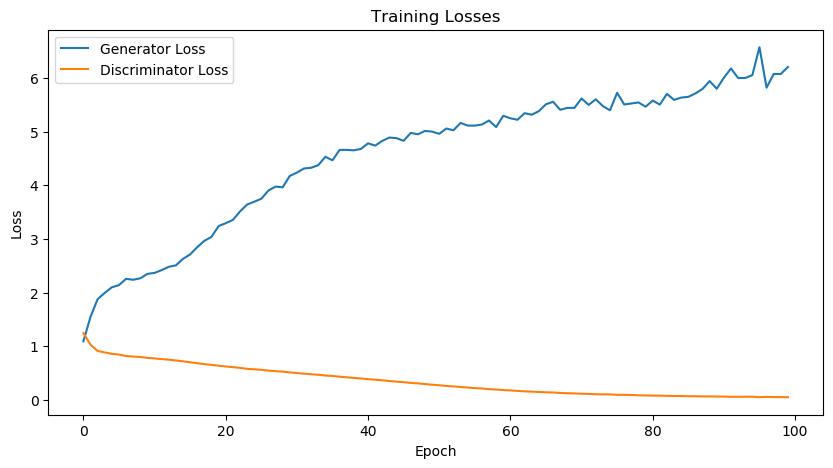

In [87]:
EPOCHS = 100
noise_dim = 100
batch_size = 32
num_examples_to_generate = 16

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# 修改后的train函数，记录并可视化损失
def train(dataset, epochs):
    gen_loss_history = []
    disc_loss_history = []
    
    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss.append(gen_loss.numpy())
            epoch_disc_loss.append(disc_loss.numpy())
        
        gen_loss_history.append(np.mean(epoch_gen_loss))
        disc_loss_history.append(np.mean(epoch_disc_loss))

        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss_history[-1]}, Discriminator Loss: {disc_loss_history[-1]}")

    # plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss_history, label='Generator Loss')
    plt.plot(disc_loss_history, label='Discriminator Loss')
    plt.title("Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
# Start training
train(train_dataset, EPOCHS)

In [59]:
# Training loop (simplified)
EPOCHS = 50
noise_dim = 100
batch_size = 50
num_examples_to_generate = 16

# Seed for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training function
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(len(data)).batch(batch_size)

# Start training
train(train_dataset, EPOCHS)


In [60]:
def generate_linear_embeddings(generator, num_points, noise_dim):
    noise = tf.random.normal([num_points, noise_dim])
    generated_data = generator(noise, training=False)
    return generated_data.numpy()

num_new_points = 10  # Number of new points to generate
new_embeddings = generate_linear_embeddings(generator, num_new_points, noise_dim)


In [63]:
new_embeddings


array([[[ 0.13735147,  0.04068665],
        [ 0.4703064 , -0.02676773],
        [-0.07422955,  0.24897933],
        ...,
        [-0.49411812,  0.14328885],
        [-0.71855974, -0.14114724],
        [ 0.47553414, -0.5430108 ]],

       [[-0.29306915, -0.5208254 ],
        [-0.11535443,  0.313688  ],
        [ 0.02353472,  0.02167772],
        ...,
        [-0.51253974,  0.1416474 ],
        [ 0.46342486, -0.00766335],
        [-0.13220723, -0.3888291 ]],

       [[ 0.09914178, -0.17839514],
        [-0.13335577,  0.32002917],
        [ 0.4318577 , -0.5924497 ],
        ...,
        [ 0.30222404,  0.17275523],
        [ 0.21344067, -0.21023907],
        [-0.1814231 , -0.28554997]],

       ...,

       [[-0.4325461 ,  0.4388237 ],
        [-0.05177539, -0.04904461],
        [ 0.29908738,  0.09347787],
        ...,
        [-0.5807975 , -0.36047018],
        [-0.1455467 ,  0.40953964],
        [ 0.48045996,  0.11895899]],

       [[-0.71266913, -0.02533825],
        [-0.59174484,  0.79